In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
class_names = ds_info.features['label'].names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

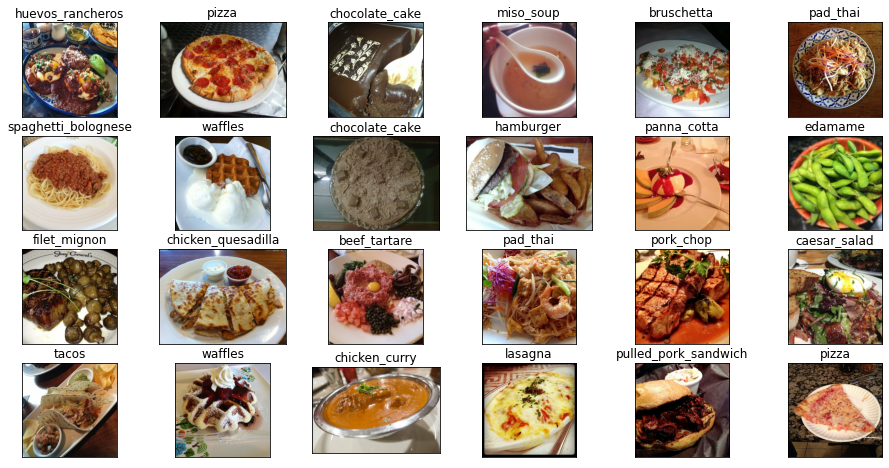

In [4]:
sample = [x for x in iter(train_ds.take(24))]
N = len(sample)
fig = plt.figure(figsize=(16, 8))
for j in range(len(sample)):
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(sample[j][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[sample[j][1]])
    plt.grid(False)
plt.show()

In [5]:
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [6]:

# Transfer Learning
EXP_NAME = 'transfer'
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
#base_model.trainable = True # Fine-tuning весов предобученной модели
base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101),
])

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
LEARNING_RATE = 0.0005
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/fine_tune', 
    write_graph=False, update_freq=100, profile_batch=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10
2130/2130 [==============================] - 784s 367ms/step - loss: 2.3000 - accuracy: 0.4416 - val_loss: 1.9121 - val_accuracy: 0.5172
Epoch 2/10
2130/2130 [==============================] - 874s 410ms/step - loss: 1.7033 - accuracy: 0.5649 - val_loss: 1.8310 - val_accuracy: 0.5375
Epoch 3/10
2130/2130 [==============================] - 822s 386ms/step - loss: 1.5308 - accuracy: 0.6035 - val_loss: 1.8160 - val_accuracy: 0.5442
Epoch 4/10
2130/2130 [==============================] - 841s 394ms/step - loss: 1.4162 - accuracy: 0.6315 - val_loss: 1.8163 - val_accuracy: 0.5470
Epoch 5/10
2130/2130 [==============================] - 977s 458ms/step - loss: 1.3303 - accuracy: 0.6534 - val_loss: 1.8148 - val_accuracy: 0.5510
Epoch 6/10
2130/2130 [==============================] - 825s 387ms/step - loss: 1.2617 - accuracy: 0.6706 - val_loss: 1.8398 - val_accuracy: 0.5485
Epoch 7/10
2130/2130 [==============================] - 932s 436ms/step - loss: 1.2048 - accuracy: 0.6829 - val_

In [10]:
%%time

model.evaluate(test_ds)

59/59 [==============================] - 79s 1s/step - loss: 1.9288 - accuracy: 0.5422
CPU times: user 2min 19s, sys: 7.7 s, total: 2min 26s
Wall time: 1min 21s


[1.9288264513015747, 0.5422404408454895]

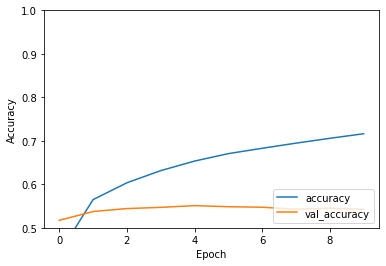

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

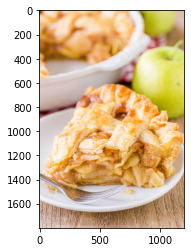

In [13]:
import imageio
from skimage.transform import resize

def prepare(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('Apple-Pie-5.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare(img)

In [14]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: apple_pie
